
# <center> Practice Case Tweets Modelling 

## Informasi Data
- Dataset yang digunakan adalah dataset dari twitter yang sudah di cleaning. 
- Data ini mempunyai 2 feature yaitu text dan target yang berisi 1600000 record.

## Tujuan Pemodelan
- Untuk memprediksi apakah tweet yang datang merupakan tweet dengan positif atau negatif

## Import Library

In [1]:
import warnings
warnings.filterwarnings("ignore") 
import pandas as pd 
import numpy as np 
import nltk 
nltk.download('stopwords')
#import nltk for natural language toolkit
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
import tqdm
#import tqdm 
from tqdm import tqdm 
tqdm.pandas()

#import string, regex, , uniqcode
import re, string, unicodedata

#import sklearn preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#import sklearn for modeling
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#import visualization module 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS


#import beaurtiful soup 
from bs4 import BeautifulSoup

#save model 
import pickle 

#textblob
from textblob import Word


[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


## Load Dataset

In [2]:
data=pd.read_csv('clean_tweet.csv')
data.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596753 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


- Dari fungsi info, dapat dilihat bahwa dataset ini berisi sebanyak 1600000 record dengan variabel berupa text yang berupa tweet dan feature target yang berupa 1 dan 0. 
- Feature Target merupakan feature sentiment. Nilai 1 adalah sentiment Positive, sedangkan 0 adalah sentiment negatif

## Check Missing Value

In [4]:
data.isna().sum()

text      3247
target       0
dtype: int64

Ternyata diketahui ada 3247 missing value pada data, oleh karena itu, Missing value ini akan dihapus dari data

In [5]:
data=data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1596753 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596753 non-null object
target    1596753 non-null int64
dtypes: int64(1), object(1)
memory usage: 36.5+ MB


# Target Proportion

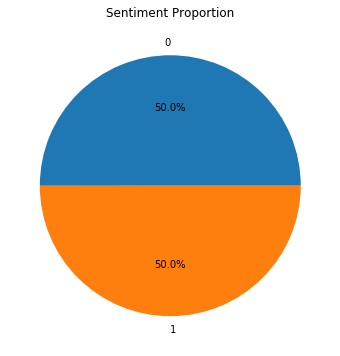

In [6]:
target=pd.DataFrame(data['target'].value_counts())
plt.figure(figsize=(6,6))
plt.pie(target,labels=target.index, autopct='%1.1f%%')
plt.title('Sentiment Proportion')
plt.show()


Dari Pie chart di atas, terlihat bahwa proporsi sentimen negatif dan positif seimbang dalam data ini

---

# Data Preprocessing

Sebelum melakukan Visualisasi ataupun Modelling, dilakukan Praproses data agar hasil nya semakin baik. Praproses data untuk data text berebeda dengan praposes data tabular biasa.
Step-step praproses data text adalah sebagai berikut :
- Lower Casing
- Punctutation Removal
- Spelling Correction
- Stemming
- Lematization

### A. Lower Casing

Praproses pertama adalah membuat semua kata menjadi lower case

In [7]:
data['text'] = data['text'].str.lower()
data['text'].head()

0    awww that s a bummer you shoulda got david car...
1    is upset that he can t update his facebook by ...
2    i dived many times for the ball managed to sav...
3       my whole body feels itchy and like its on fire
4    no it s not behaving at all i m mad why am i h...
Name: text, dtype: object

### B. Punctuation Removal

Punctuation Removal digunakan untuk membuang tanda baca dalam data teks

In [8]:
data['text'] = data['text'].str.replace('[^\w\s]','')
data.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


### C. Spelling Correction

Spelling Correction digunakan untuk merubah kata-kata yang typo menjadi kata baku

In [31]:
#import textblob 
from textblob import TextBlob
data['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    www that s a summer you should got david care ...
1    is upset that he can t update his facebook by ...
2    i dived many times for the ball managed to sav...
3       my whole body feels itchy and like its on fire
4    no it s not behaving at all i m mad why am i h...
Name: text, dtype: object

### D. Stemming

Stemming digunakan untuk mengubah kata berimbuhan menjadi kata dasar 

In [40]:
from nltk.stem import PorterStemmer
st = PorterStemmer()
data['text'] = data['text'][:].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

### E. Lematization

Lematization digunakan untuk membuang kata-kata yang tidak baku pada dataset

In [ ]:
from textblob import Word
dataframe['text'] = dataframe['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
dataframe['text'].head()

# Wordcloud for Negative-Positive Sentiment

A word cloud is a popular visualization of words typically associated with tweet keywords and text data. They are most commonly used to highlight popular or trending terms based on frequency of use and prominence. A word cloud is a beautiful, informative image that communicates much in a single glance.

In [43]:
#define negative, positive, and neutral 
negative = data.loc[data['target'] == 0]['text']
positive  = data.loc[data['target'] == 1]['text']


In [45]:
#merge all the sentiment comments into one paragraph
all_description_negative = "".join(negative.values)
all_description_positive = "".join(positive.values)

In [44]:
#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

### Wordcloud for Negative Sentiment

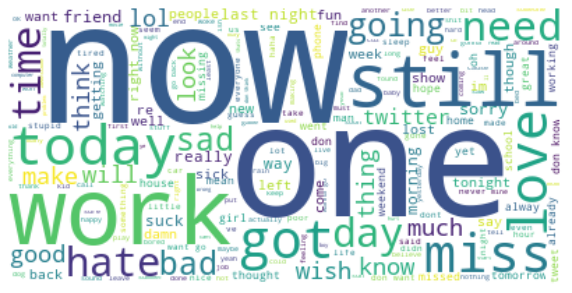

In [46]:
#negative 
plt.figure(figsize=(10,10))
create_word_cloud(all_description_negative)
plt.show()

### Wordcloud for Positive Sentiment

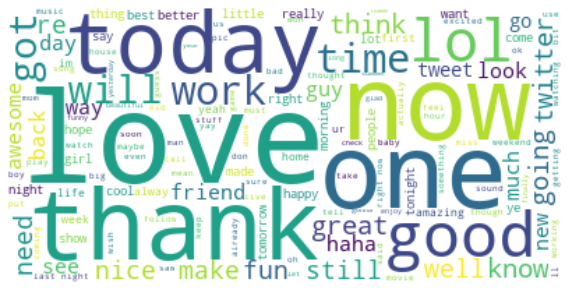

In [47]:
#positive 
plt.figure(figsize=(10,10))
create_word_cloud(all_description_positive)
plt.show()

# Modelling
### Steps for Modelling :
- Define X and y
- Feature Extraction (Count Vectorizer, TF-IDF)
- Split Data Training and Testing
- Modelling
- Hyperparameter Tuning
- Evaluation

### A. Define X and y

In [9]:
X = data['text']
y = data['target']

### B. Feature Extraction

#### Count Vectorizer

The most straightforward one, it counts the number of times a token shows up in the document and uses this value as its weight.

CountVectorizer builds a count matrix where rows are occurrences counts of different words taking into account the high-dimensional sparsity.


In [10]:
count_vectorizer = CountVectorizer(stop_words='english')

#### TF-IDF

TF-IDF stands for “term frequency-inverse document frequency”, meaning the weight assigned to each token not only depends on its frequency in a document but also how recurrent that term is in the entire corpora. 

Tf-idf stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

In [11]:
tfidf = TfidfVectorizer(stop_words='english' )

In [12]:
#countvectorizer
X_vectorizer = count_vectorizer.fit_transform(X)

#tfidf vectorizer
X_tfidf = tfidf.fit_transform(X)

### Split Data Training and Data testing with Proportion 70% and 30%

In [13]:
#train test split using countvectorizer 
train_X_vectorizer, test_X_vectorizer, train_y, test_y = train_test_split(X_vectorizer, y, test_size=0.2, random_state=0)

#train test split using tfidfvectorizer 
train_X_tfidf, test_X_tfidf, train_y, test_y = train_test_split(X_tfidf, y, test_size=0.2, random_state=0)

## Machine Learning Modelling
Machine Learning Algorithm that will be used to predict the Sentiment are 
1. Logistics Regression
2. Multinomial Naive Bayes
3. Gaussian Naive Bayes

## Evaluation
Evaluasi yang akan digunakan adalah Akurasi, precision, dan recall untuk menentukan model mana yang terbaik untuk memprediksi sentiment 

### A. Logistics Regression

In [14]:
# Countvectorizer 
Lr_vect = LogisticRegression(penalty='l2')
Lr_vect.fit(train_X_vectorizer,train_y)
Lr_pred_vect_train = Lr_vect.predict(train_X_vectorizer)
Lr_pred_vect_test = Lr_vect.predict(test_X_vectorizer)

In [15]:
# TFIDFVectorizer
Lr_tfidf = LogisticRegression(penalty='l2')
Lr_tfidf.fit(train_X_tfidf,train_y)
Lr_pred_tfidf_train = Lr_tfidf.predict(train_X_tfidf)
Lr_pred_tfidf_test = Lr_tfidf.predict(test_X_tfidf)

In [16]:
# using count vectorizer
print("______________ Countvectorizer ______________")

lr_accuracy_train=Lr_vect.score(train_X_vectorizer,train_y)
lr_accuracy_test=Lr_vect.score(test_X_vectorizer,test_y)

Lr_recall_vec_train = recall_score(train_y, Lr_pred_vect_train)
Lr_recall_vec_test = recall_score(test_y, Lr_pred_vect_test) 

Lr_precision_vec_train = precision_score(train_y, Lr_pred_vect_train)
Lr_precision_vec_test = precision_score(test_y, Lr_pred_vect_test)

Lr_f1_score_vec_train = f1_score(train_y, Lr_pred_vect_train)
Lr_f1_score_vec_test = f1_score(test_y,Lr_pred_vect_test)


print('Information :')
print('Accuracy train & test   : %.2f%%' % (lr_accuracy_train * 100), '&', '%.2f%%' % (lr_accuracy_test * 100))
print('Recall train & test     : %.2f%%' % (Lr_recall_vec_train * 100), '&', '%.2f%%' % (Lr_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_vec_train * 100), '&', '%.2f%%' % (Lr_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_vec_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Accuracy train & test   : 80.98% & 77.55%
Recall train & test     : 83.14% & 80.14%
Precision train & test  : 79.70% & 76.18%
F1 Score train & test   : 81.39% & 78.11%


In [17]:
# using count vectorizer
print("______________ TF-IDF ______________")

lr_accuracy_train=Lr_tfidf.score(train_X_tfidf,train_y)
lr_accuracy_test=Lr_tfidf.score(test_X_tfidf,test_y)

Lr_recall_tfidf_train = recall_score(train_y, Lr_pred_tfidf_train, average="micro")
Lr_recall_tfidf_test = recall_score(test_y, Lr_pred_tfidf_test,average="micro") 

Lr_precision_tfidf_train = precision_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_precision_tfidf_test = precision_score(test_y, Lr_pred_tfidf_test,average="micro")

Lr_f1_score_tfidf_train = f1_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_f1_score_tfidf_test = f1_score(test_y,Lr_pred_tfidf_test,average="micro")

print('Information :')
print('Accuracy train & test   : %.2f%%' % (lr_accuracy_train * 100), '&', '%.2f%%' % (lr_accuracy_test * 100))
print('Recall train & test     : %.2f%%' % (Lr_recall_tfidf_train * 100), '&', '%.2f%%' % (Lr_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_tfidf_train * 100), '&', '%.2f%%' % (Lr_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_tfidf_train * 100), '&', '%.2f%%' % (Lr_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Accuracy train & test   : 80.11% & 77.72%
Recall train & test     : 80.11% & 77.72%
Precision train & test  : 80.11% & 77.72%
F1 Score train & test   : 80.11% & 78.11%


## Naive Bayes

In [18]:
# Countvectorizer
NB_vect = MultinomialNB()
NB_vect.fit(train_X_vectorizer,train_y)
NB_pred_vect_train = NB_vect.predict(train_X_vectorizer)
NB_pred_vect_test = NB_vect.predict(test_X_vectorizer)

In [19]:
# TFIDFVectorizer
#from sklearn.naive_bayes import GaussianNB
NB_tfidf = MultinomialNB()
NB_tfidf.fit(train_X_tfidf,train_y)
NB_pred_tfidf_train = NB_tfidf.predict(train_X_tfidf)
NB_pred_tfidf_test = NB_tfidf.predict(test_X_tfidf)

In [21]:
# find model evaluation for naive bayes
# using count vectorizer
print("______________ Countvectorizer ______________")

NB_accuracy_train=Lr_tfidf.score(train_X_vectorizer,train_y)
NB_accuracy_test=Lr_tfidf.score(test_X_vectorizer,test_y)

NB_recall_vec_train = recall_score(train_y, NB_pred_vect_train, average="micro")
NB_recall_vec_test = recall_score(test_y, NB_pred_vect_test,average="micro") 

NB_precision_vec_train = precision_score(train_y, NB_pred_vect_train,average="micro")
NB_precision_vec_test = precision_score(test_y, NB_pred_vect_test,average="micro")

NB_f1_score_vec_train = f1_score(train_y, NB_pred_vect_train,average="micro")
NB_f1_score_vec_test = f1_score(test_y,NB_pred_vect_test,average="micro")

print('Information :')
print('Accuracy train & test   : %.2f%%' % (NB_accuracy_train * 100), '&', '%.2f%%' % (NB_accuracy_test * 100))
print('Recall train & test     : %.2f%%' % (NB_recall_vec_train * 100), '&', '%.2f%%' % (NB_recall_vec_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_vec_train * 100), '&', '%.2f%%' % (NB_precision_vec_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_vec_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

______________ Countvectorizer ______________
Information :
Accuracy train & test   : 78.99% & 77.35%
Recall train & test     : 79.65% & 76.65%
Precision train & test  : 79.65% & 76.65%
F1 Score train & test   : 79.65% & 76.65%


In [22]:
# using count vectorizer
print("______________ TF-IDF ______________")

NB_accuracy_train=Lr_tfidf.score(train_X_tfidf,train_y)
NB_accuracy_test=Lr_tfidf.score(test_X_tfidf,test_y)

NB_recall_tfidf_train = recall_score(train_y, NB_pred_tfidf_train, average="micro")
NB_recall_tfidf_test = recall_score(test_y, NB_pred_tfidf_test,average="micro") 

NB_precision_tfidf_train = precision_score(train_y, NB_pred_tfidf_train,average="micro")
NB_precision_tfidf_test = precision_score(test_y, NB_pred_tfidf_test,average="micro")

NB_f1_score_tfidf_train = f1_score(train_y, NB_pred_tfidf_train,average="micro")
NB_f1_score_tfidf_test = f1_score(test_y,NB_pred_tfidf_test,average="micro")

print('Information :')
print('Accuracy train & test   : %.2f%%' % (NB_accuracy_train * 100), '&', '%.2f%%' % (NB_accuracy_test * 100))
print('Recall train & test     : %.2f%%' % (NB_recall_tfidf_train * 100), '&', '%.2f%%' % (NB_recall_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_tfidf_train * 100), '&', '%.2f%%' % (NB_precision_tfidf_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_tfidf_train * 100), '&', '%.2f%%' % (NB_f1_score_vec_test * 100))

______________ TF-IDF ______________
Information :
Accuracy train & test   : 80.11% & 77.72%
Recall train & test     : 79.63% & 76.04%
Precision train & test  : 79.63% & 76.04%
F1 Score train & test   : 79.63% & 76.65%


# Tuning Parameter Logistics Regression

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV            
p_test3 = {'penalty':['l1','l2'], 'C':[0.01,0.1,1,5,10]}

tuning = GridSearchCV(estimator =LogisticRegression(), 
            param_grid = p_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(train_X_vectorizer,train_y)
tuning.best_params_, tuning.best_score_

({'C': 1, 'penalty': 'l1'}, 0.7757628375596751)

Setelah dilakukan Tuning parameter, didapatkan parameter terbaik yaitu Penalty= l1 dan C =1.
<br>Model ini akan digunakan untuk memprediksi tweet yang masuk

# Model Evaluation Using Confusion Matrix and ROC Curve

              precision    recall  f1-score   support

           0       0.77      0.79      0.78    159771
           1       0.78      0.76      0.77    159580

   micro avg       0.77      0.77      0.77    319351
   macro avg       0.77      0.77      0.77    319351
weighted avg       0.77      0.77      0.77    319351

Accuracy   : 77.34530344354644
Recall     : 75.93307432009023
Precision  : 78.11831145723201
AUC        : 77.34445931112384


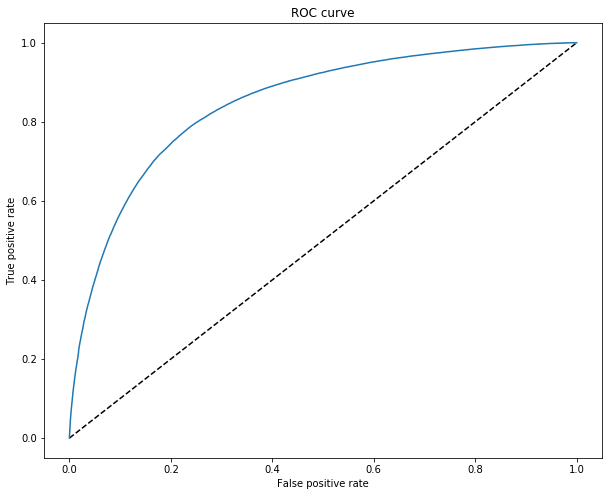

In [39]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_ensemble):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')

    fpr, tpr, _ = roc_curve(test_y, P_ensemble)
    plt.plot(fpr, tpr)
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()

print(classification_report(test_y,Lr_Pred))
print('Accuracy   :',accuracy_score(test_y,Lr_Pred)*100)
print('Recall     :',recall_score(test_y,Lr_Pred)*100)
print('Precision  :',precision_score(test_y,Lr_Pred)*100)
print('AUC        :',roc_auc_score(test_y,Lr_Pred)*100)

y_pred_proba=Lr_tfidf.predict_proba(test_X_vectorizer)
plot_roc_curve(test_y,y_pred_proba[:,1])

# Kesimpulan
1. Kesimpulan yang didapat dari hasil visualisasi dan modelling dari data ini adalah data teks perlu dilakukan data praprosesing dahulu sebelum dilakukan modelling ataupun visualisasi.
2. Ada dua feature extraction yang digunakan, yaitu Countvectorizer dan TF-IDF, dari dua method ini akan dilihat mana feature extraction yang memberikan hasil terbaik saat pemodelan.
3. Model yang digunakan ada 2 yaitu Logistics Regression dan Multinomial Naive Bayes. Model dengan evaluasi tertinggi adalah Regresi Logistics dengan Feature Extractionnya adalah TF-IDF
4. Setelah didapatkan Model terbaik, akan dilakukan Tuning Parameter untuk meningkatkan hasil akurasi. Parameter yang dituning adalah Penalty berupa l1 dan C=1.

# Thanks
Created by : Fransdana Nadeak